# Metadata

```yaml
course:   DS 5001 
topic:    Word Embeddings 
author:   Andrew Chaphiv (acgq2@virginia.edu)
date:    SPR2023
```


# Hyperparameters

In [99]:
w2v_params = dict(
    window = 2,
    vector_size = 256,
    min_count = 50,
    workers = 4
)

# Importing Modules and Data

In [2]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [4]:
OHCO = ['abstract_num', 'sent_num']
years = ['1995', '2000', '2005', '2010', '2015', '2020', '2023']

In [6]:
TOKENS = pd.read_csv('abstracts-CORPUS.csv').set_index(OHCO)
LIB = pd.read_csv('abstracts-LIB.csv')

In [7]:
LIB

,abstract_num,Title,Authors,Abstract,Year,Abstract Length
0,0,Stimulation of the sphingomyelin pathway induc...,"Fiebich BL(1), Lieb K, Berger M, Bauer J.",Interleukin-6 (IL-6) has previously been shown...,1995,843
1,1,Non-parametric estimation of the post-lead-tim...,"Xu JL(1), Prorok PC.",The goal of screening programmes for cancer is...,1995,1186
2,2,Non-parametric methods for analysing recurrent...,"Lancar R(1), Kramar A, Haie-Meder C.",Non-parametric methods have recently been prop...,1995,706
3,3,Effect of serum albumin on estrogen metabolism...,"Bradlow HL(1), Arcuri F, Blasi L, Castagnetta L.",The observation that charcoal-treated fetal bo...,1995,1251
4,4,Effect of a new de-N-acetyl-lysoglycosphingoli...,"Tubaro E(1), Borelli GP, Belogi L, Cavallo G, ...",A new de-N-acetylated glycosphingolipid termed...,1995,970
...,...,...,...,...,...,...
9793,9793,Unmet Needs and Receipt of Supportive Care Ser...,"Day AT(1), Prestwood CA(1), Emmett TR(1), Eary...",OBJECTIVE: To characterize the supportive care...,2023,1634
9794,9794,The Intersection of Race and Rurality and its ...,"Tobin EC(1), Nolan N(2), Thompson S(1), Elmore...",INTRODUCTION: Outcomes in colorectal cancer tr...,2023,1839
9795,9795,Upregulation of Coagulation Factor VIII and Fi...,"Myllylahti L(1), Ropponen J(2), Lax M(3), Lass...",OBJECTIVES: Chronic thromboembolic pulmonary h...,2023,1318
9796,9796,A Study of 57 Patients with Prostate Cancer to...,"Hwang BY(1)(2), Lee D(1)(2), Kwon JY(2), Kim O...",BACKGROUND Robot-assisted radical prostatectom...,2023,1676


In [53]:
def generate_word_embedding(year):  # Created a funciton to generate word embedding based on the year 
    abstract_ids = LIB[LIB["Year"]==year]["abstract_num"].to_list()
    TOKENS.loc[abstract_ids, 'year'] = year
    year_df = TOKENS[TOKENS['year'] == year]
    year_vocab = year_df.term_str.value_counts().to_frame('n').sort_index()
    year_vocab.index.name = 'term_str'
    year_vocab['max_pos'] = year_df[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
    year_vocab['size'] = np.log(year_vocab.n)
    year_vocab['pos_group'] = year_vocab['max_pos'].apply(lambda x: x[0:2])
    year_docs = year_df[~year_df.pos.str.match('NNPS?')]\
    .groupby(OHCO)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
    year_docs = [doc for doc in year_docs if len(doc) > 1]
    year_model = word2vec.Word2Vec(year_docs, **w2v_params)
    coords_year = pd.DataFrame(
    dict(
        vector = [year_model.wv.get_vector(w) for w in year_model.wv.key_to_index], 
        term_str = year_model.wv.key_to_index.keys()
    )).set_index('term_str')
    tsne_engine = TSNE(perplexity=20, n_components=2, init='random', n_iter=1000, learning_rate = 200,random_state=42)
    tsne_model = tsne_engine.fit_transform(coords_year.vector.to_list())
    coords_year['x'] = tsne_model[:,0]
    coords_year['y'] = tsne_model[:,1]

    if coords_year.shape[1] == 3:
        coords_year = coords_year.merge(year_vocab.reset_index(), on='term_str')
        coords_year = coords_year.set_index('term_str')
    
    return coords_year

In [94]:
def complete_analogy(model_name, A, B, C, n=2): # Semantic Algebra
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model_name.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(model_name, positive, negative=None):
    return pd.DataFrame(model_name.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [54]:
 year1995 = generate_word_embedding(1995)
year2000 = generate_word_embedding(2000)
year2005 = generate_word_embedding(2005)
year2010 = generate_word_embedding(2010)
year2015 = generate_word_embedding(2015)
year2020 = generate_word_embedding(2020)
year2023 = generate_word_embedding(2023)


In [15]:
# Separate chunk of code to generate model for entire Vocab, includes all years
VOCAB = TOKENS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['size'] = np.log(VOCAB.n)
VOCAB['pos_group'] = VOCAB['max_pos'].apply(lambda x: x[0:2])
DOCS = TOKENS[~TOKENS.pos.str.match('NNPS?')]\
.groupby(OHCO)\
.term_str.apply(lambda  x:  x.tolist())\
.reset_index()['term_str'].tolist()
DOCS = [doc for doc in DOCS if len(doc) > 1]
model = word2vec.Word2Vec(DOCS, **w2v_params)
coords = pd.DataFrame(
    dict(
        vector = [model.wv.get_vector(w) for w in model.wv.key_to_index], 
        term_str = model.wv.key_to_index.keys()
)).set_index('term_str')
    
tsne_engine = TSNE(perplexity=20, n_components=2, init='random', n_iter=1000, learning_rate = 200,random_state=42)
tsne_model = tsne_engine.fit_transform(coords.vector.to_list())
coords['x'] = tsne_model[:,0]
coords['y'] = tsne_model[:,1]

if coords.shape[1] == 3:
    coords= coords.merge(VOCAB.reset_index(), on='term_str')
    coords= coords.set_index('term_str')

In [102]:
coords.to_csv("abstracts-WORDEMBBED.csv")

# Visualization 

In [98]:
complete_analogy(model, "chemotherapy", "immunotherapy", "radiotherapy",3)

,term,sim
0,vaccines,0.677096
1,prophylactic,0.651746
2,prophylaxis,0.641402


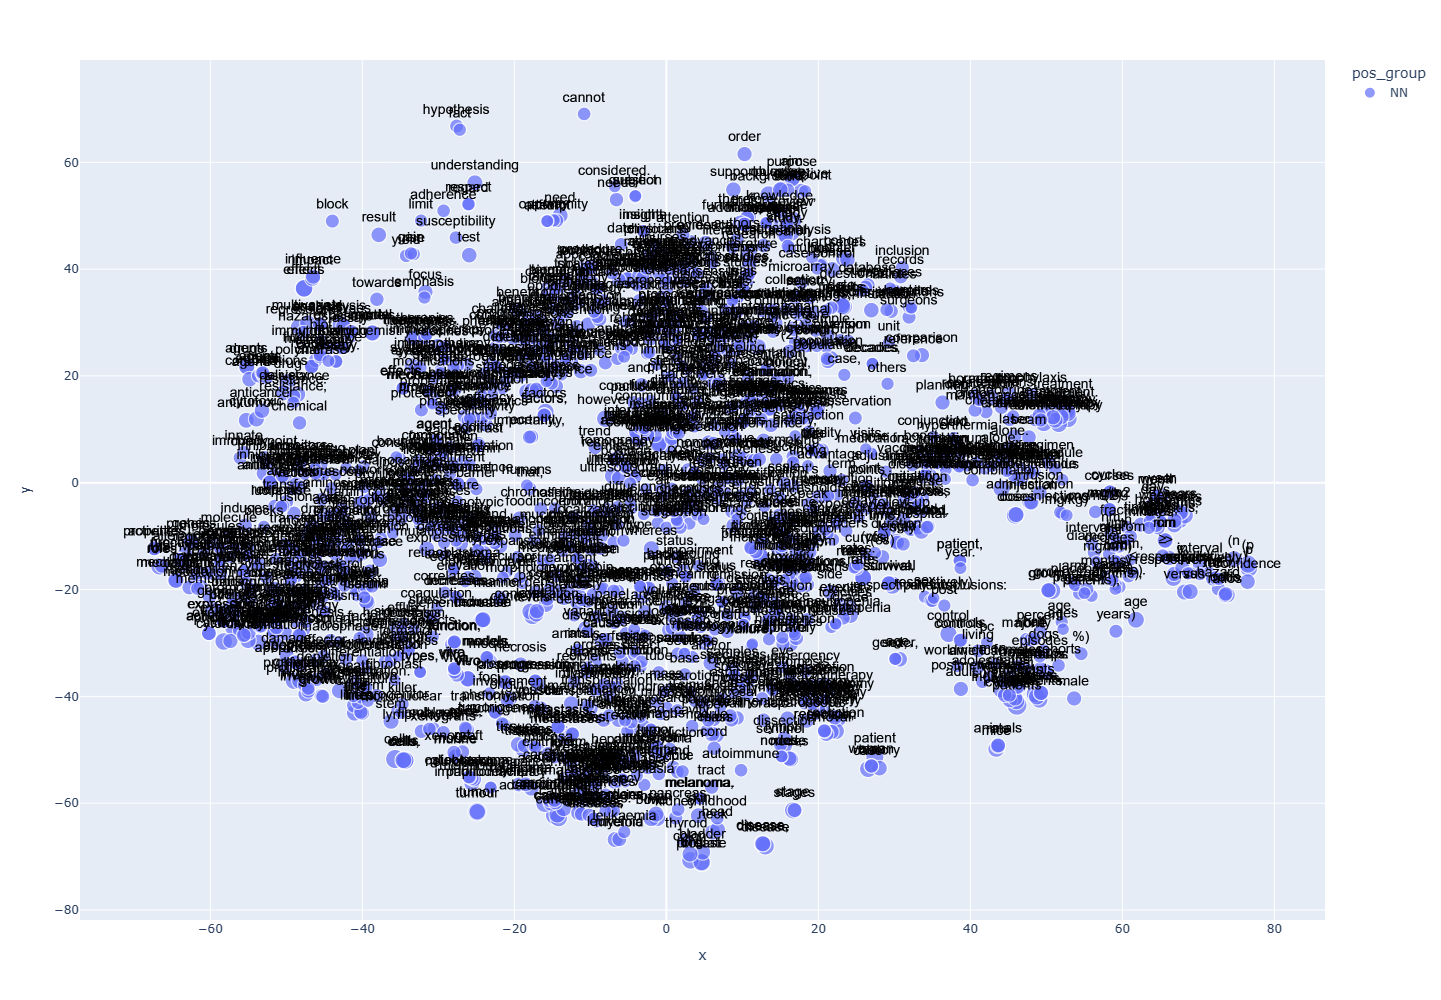

In [31]:
px.scatter(coords[coords['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

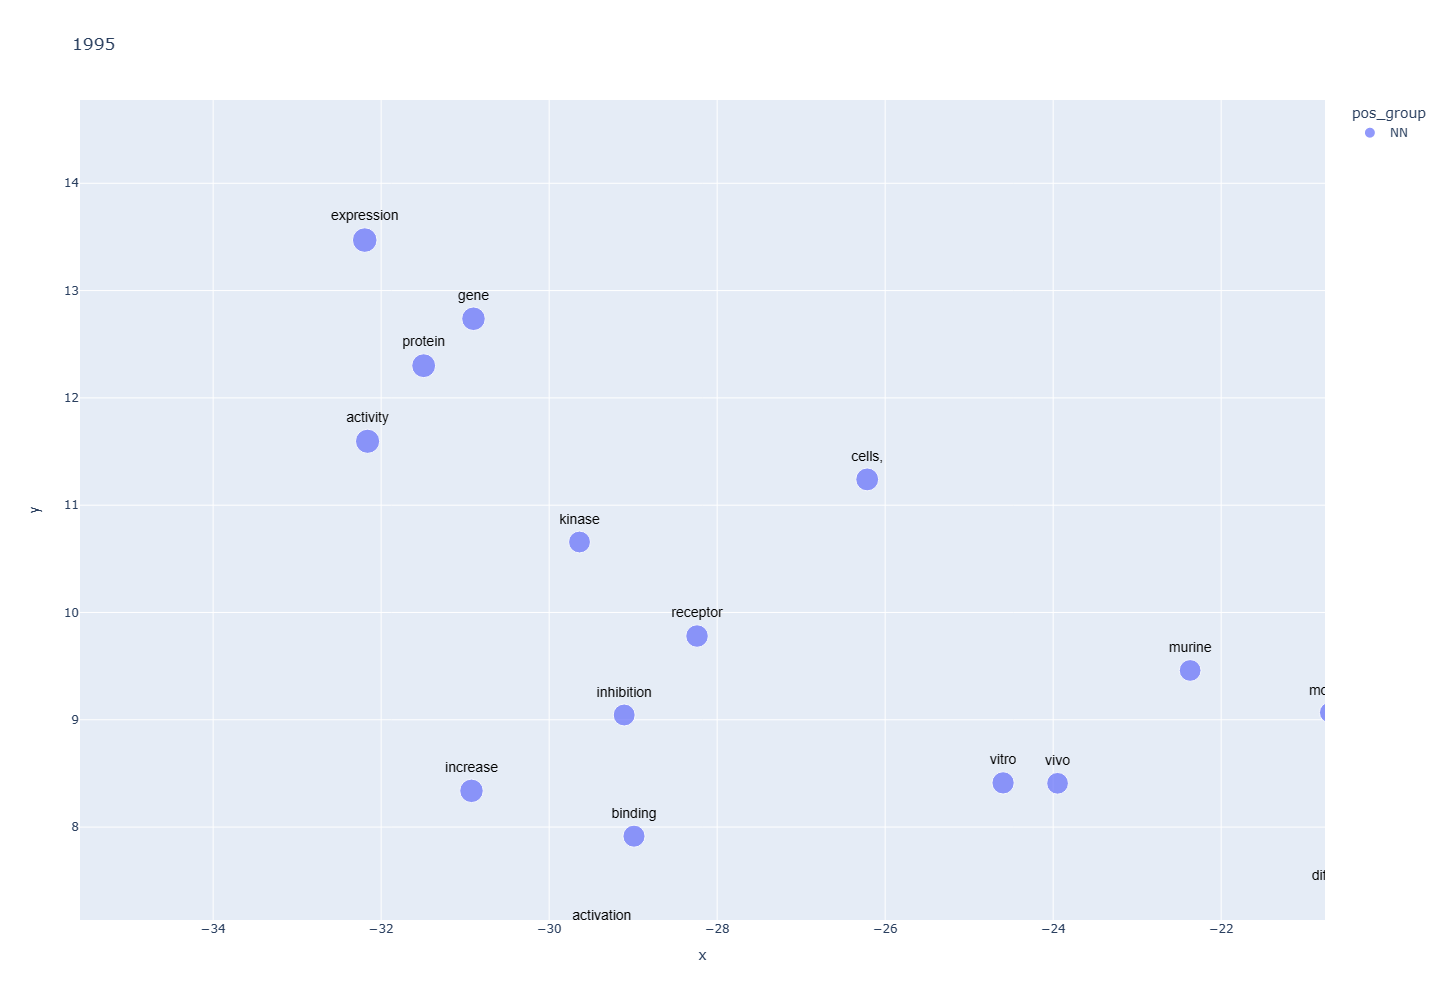

In [45]:
px.scatter(year1995[year1995['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           title = '1995',
           color='pos_group', 
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

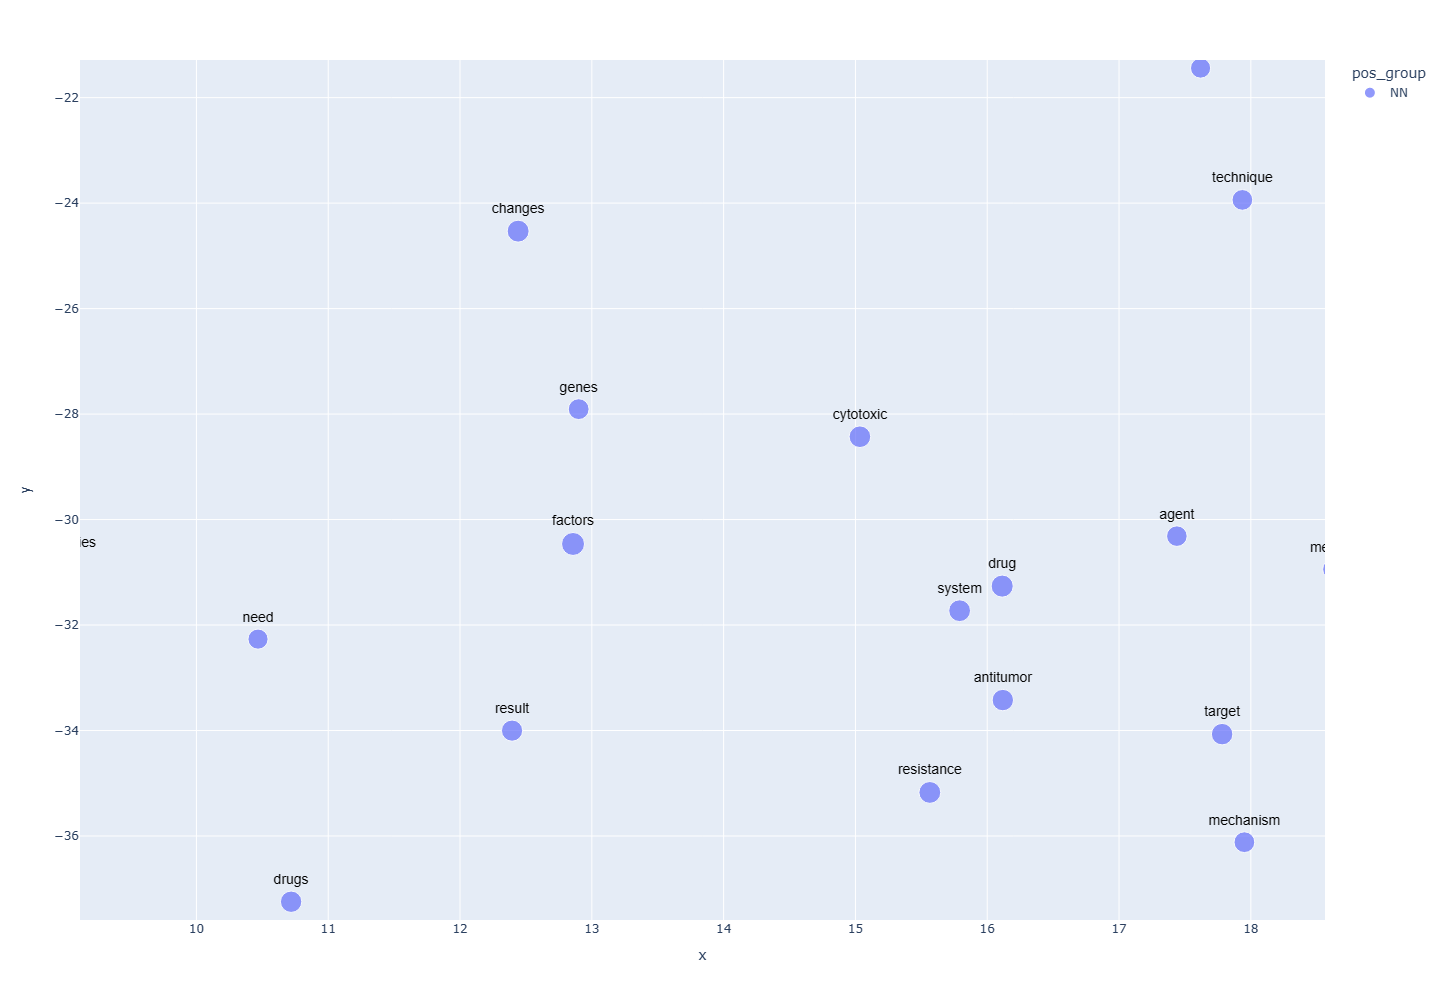

In [23]:
px.scatter(year2000[year2000['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

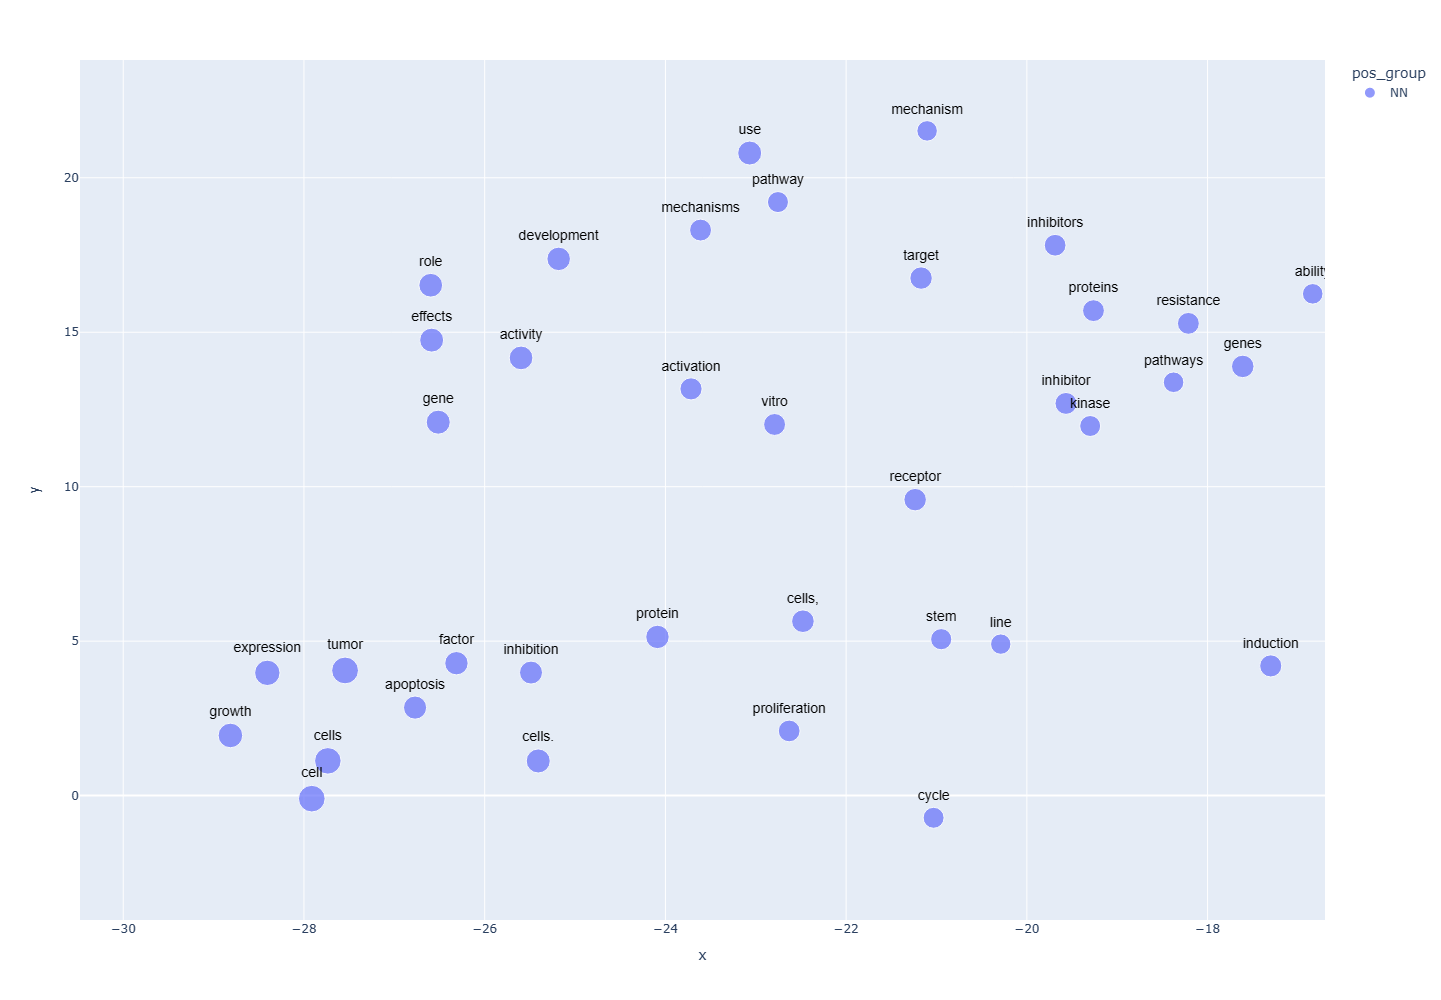

In [25]:
px.scatter(year2005[year2005['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

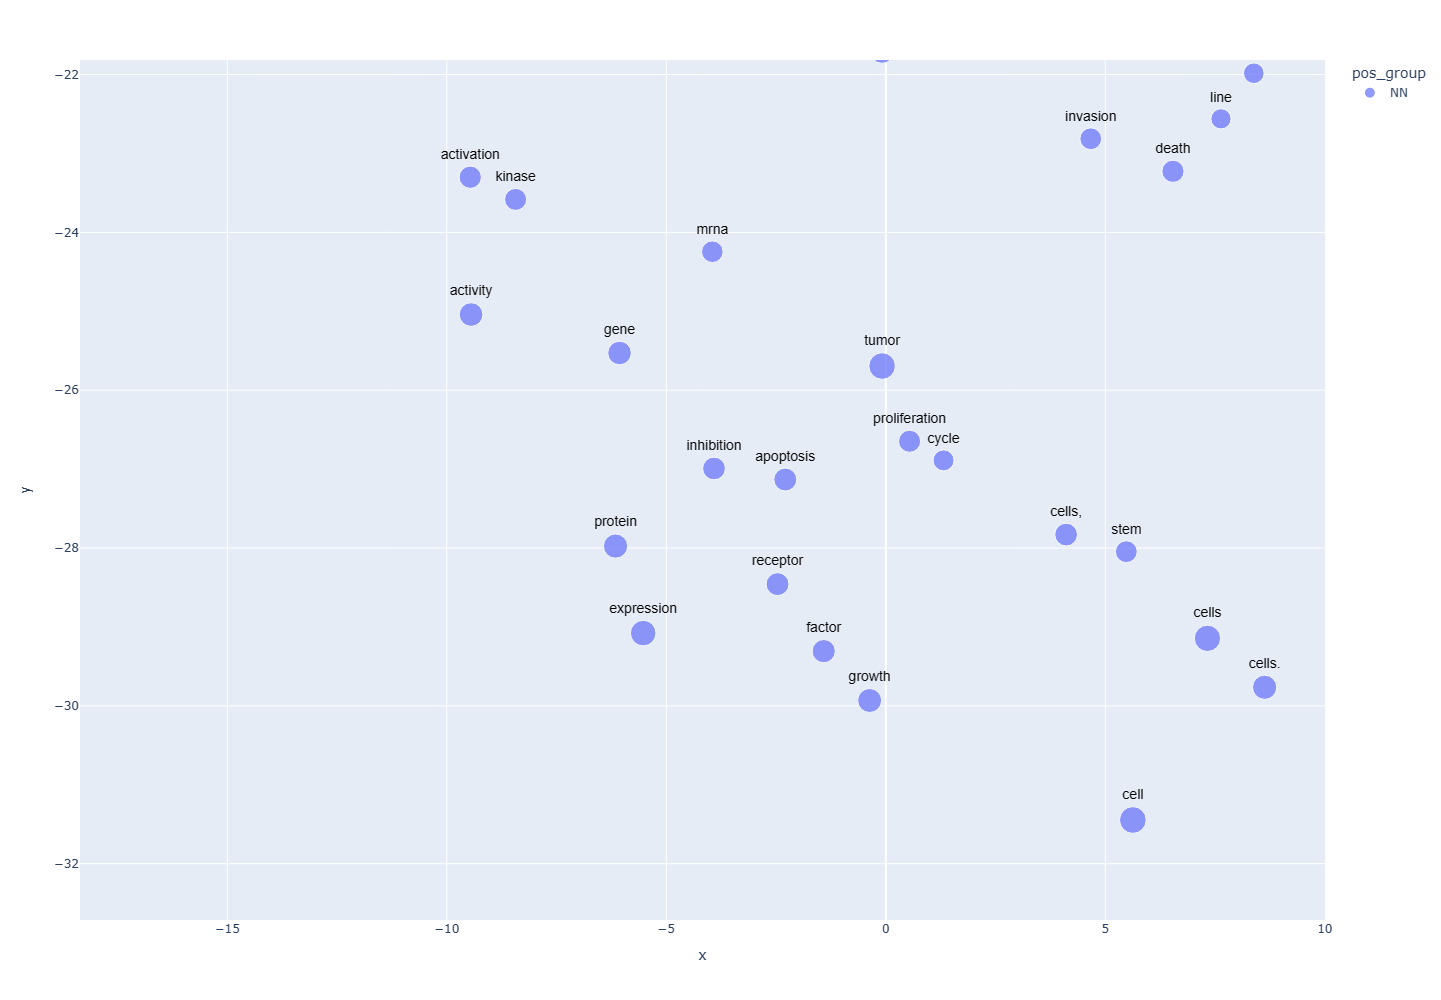

In [26]:
px.scatter(year2010[year2010['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

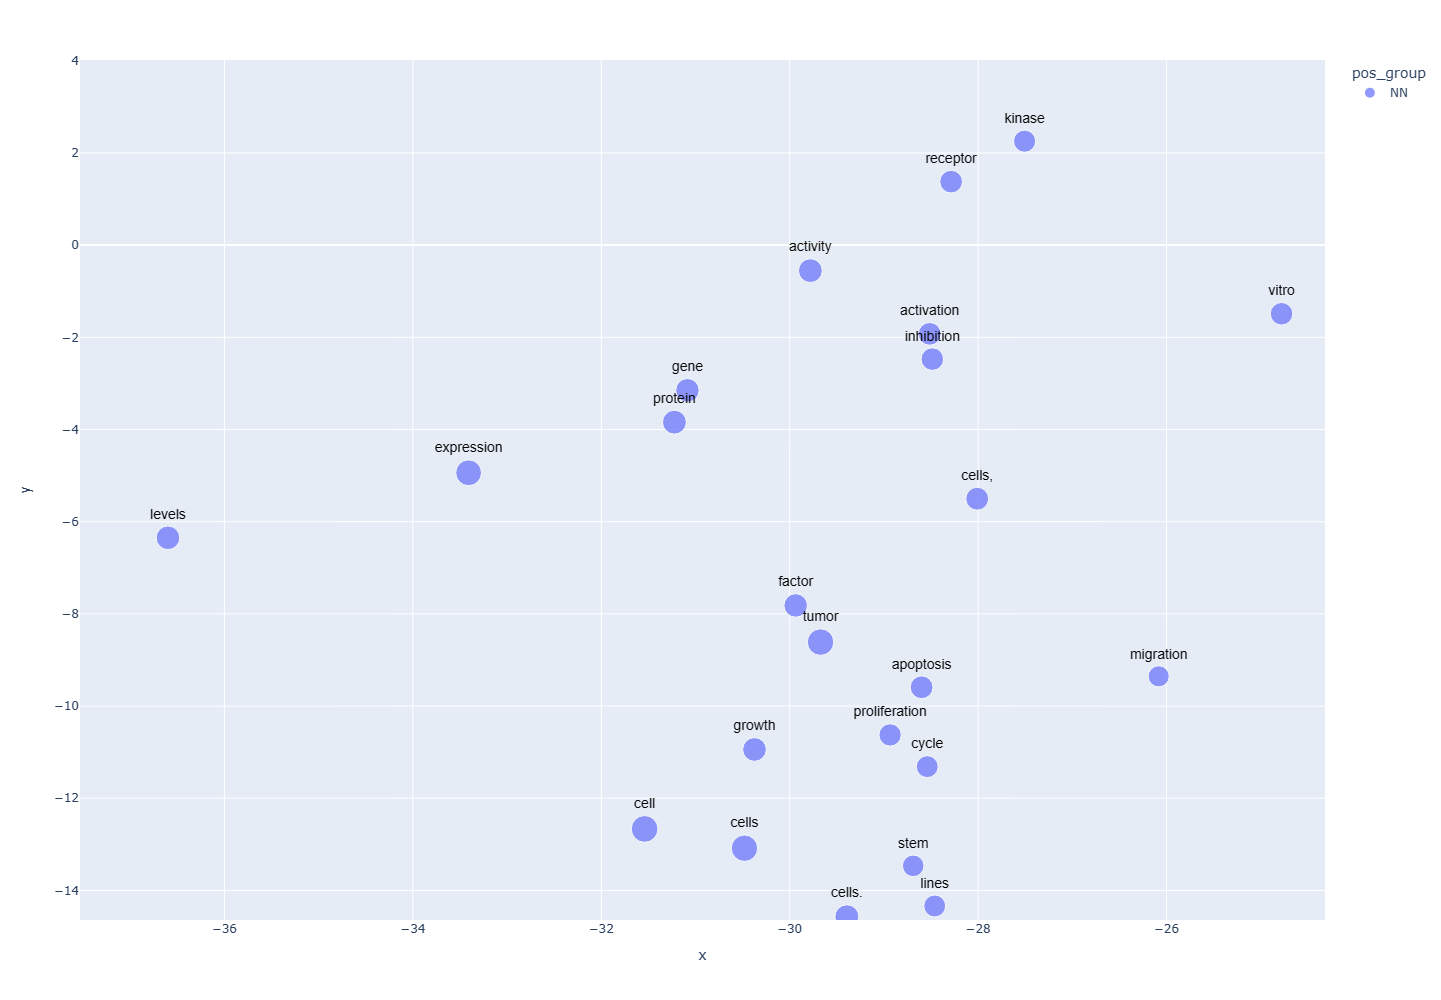

In [27]:
px.scatter(year2015[year2015['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

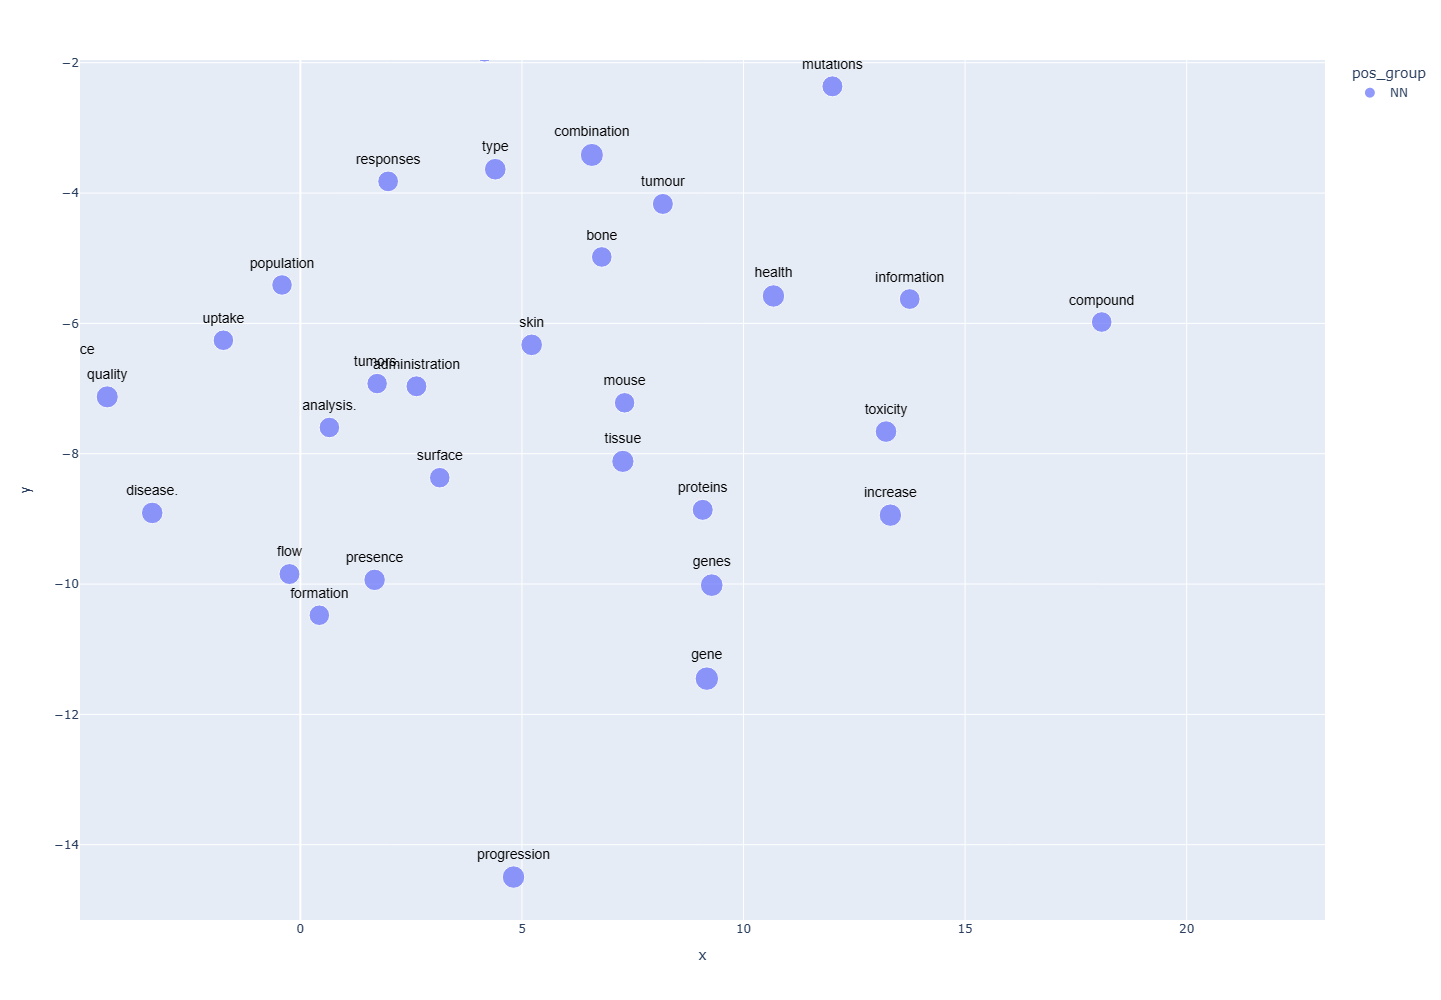

In [29]:
px.scatter(year2020[year2020['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

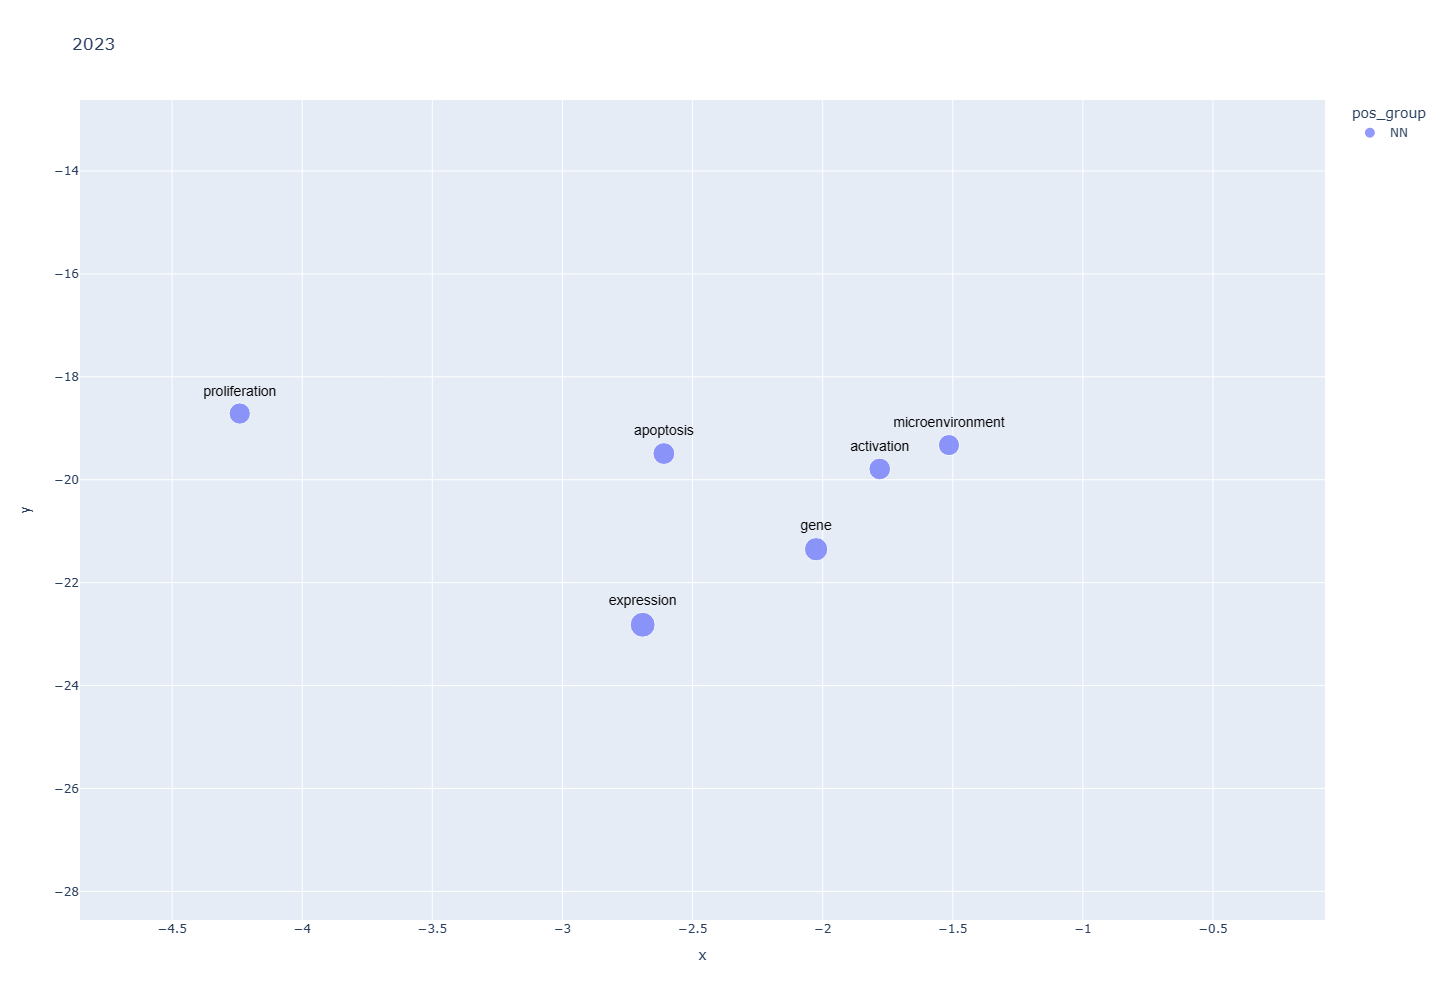

In [46]:
px.scatter(year2023[year2023['pos_group'] == "NN"].reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           title = '2023',
           hover_name='term_str',          
           size='size',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Hierarchical Clustering

In [39]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hca(sims, labels, linkage_method='ward', color_thresh=.3):
    tree = sch.linkage(sims, method=linkage_method)
    fig_height = len(labels) / 3
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, fig_height))
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

def plot_terms_tree(coords, terms_n = 100, term_pos_pat = r'^(N|V)', color_thresh=1):
    term_filter = coords.max_pos.str.match(term_pos_pat) & (coords.stop == 0) & (coords.index.str.len() > 2)
    M = coords[term_filter].sort_values('tfidf_sum', ascending=False).vector.head(terms_n)
    IDX = coords.loc[M.index].index #term_str
    hca(M.to_list(), IDX.to_list(), color_thresh=color_thresh)

In [40]:
ANNOTATED_VOCAB = pd.read_csv("abstracts-VOCAB.csv").set_index('term_str')
coords['tfidf_sum'] = ANNOTATED_VOCAB['tfidf_sum']
coords['stop'] = ANNOTATED_VOCAB['stop']

<Figure size 432x288 with 0 Axes>

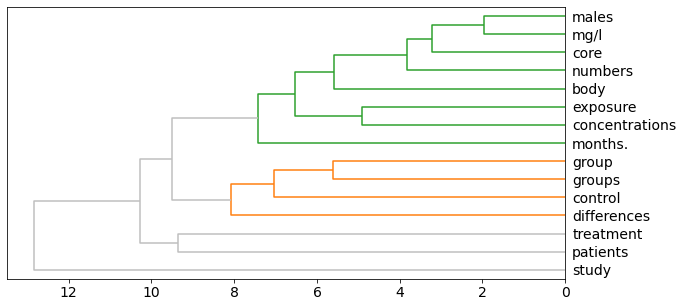

In [44]:
plot_terms_tree(coords, term_pos_pat=r'^NN[^P]?', color_thresh=9, terms_n=15)
